# Supervised Stylometric Analysis of the Pentateuch

### Table of Contents
1. [Introduction](#intro)
2. [Preprocess Data](#preprocess)
3. [Embedding Experimentation](#embed)   
4. [Results](#results)  


<a name='intro'></a>
### 1. Introduction
Modern biblical scholarship holds that the Pentateuch, also known as the Torah, is a multiauthor document that was composed over a period hundreds of years. However, scholars disagree on the number of and circumstance of the authors who have contributed to the Torah with some adhering to the older documentary hypothesis (DH) and many others prescribing to the newer, supplementary hypothesis (SH). This work aims to shed light on this controversy using Natural Language Processing (NLP) to identify the authors of the Torah at the sentence level. Computerized stylometric analysis in this piece reveals an intricate story showing the lack of a strong stylometric signature from the E source over the J source and a strong seepage of the P source into sources thought to be independent by the documentary hypothesis. 

In [1]:
from linear_assignment_ import linear_assignment

import numpy as np
import pandas as pd 
import itertools

from scipy.spatial import distance

import fasttext
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn import ensemble, linear_model, metrics, model_selection, naive_bayes
from gensim.models import Word2Vec, word2vec, KeyedVectors

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

color = sns.color_palette()
np.set_printoptions(suppress=True)
%matplotlib inline

/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [2]:
def word_vector(model, tokens, dim):
    """ 
    Generate a word vector.
    model: a completed model
    tokens: a list of words (in this case POS)
    dim: Number of dimensions. 100 - 300 is good for w2v
    """
    
    i = 0
    vec = np.zeros(dim).reshape((1, dim))
    for word in tokens:
        vec += model[word].reshape((1, dim))
        i += 1.
    if i != 0:
        vec /= i
    return vec

In [3]:
def clean_label(y_true, y_pred):
    """
    Unsupervised classifiers do not always choose the same labels. For example, on one run the J author may be labled
    0, on the next they may be labeled 3. This function will best match the labels and convert the later set of
    labels so that all 3's in y_pred become 0's to match up with y_true. 
    This enables easy comparison and the possibility to run metrics.
    
    Input y_true and y_pred, numpy.arrays containing the true and predicted labels for a model.
    Returns y_pred converted to the same numeric key as y_true.
    """
    
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    d = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((d, d), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)

    key = {}
    for l in ind:
        key[l[0]] = l[1]
        
    y_pred_clean = []
    for label in y_pred:
        y_pred_clean.append(key[label])
    y_pred_clean = np.array(y_pred_clean)
    
    return y_pred_clean

In [4]:
def flatten_list(unflattened_list):
    
    return [item for sublist in unflattened_list for item in sublist]

def get_core_indices(data, cluster_indices):
    
    cluster_mean = np.mean(data[cluster_indices], axis=0)
    angles = [distance.euclidean(data[i, ], cluster_mean) for i in cluster_indices]
    return [cluster_indices[i] for i in range(len(cluster_indices)) if np.mean(angles) - 2 * np.std(angles) < angles[i] < np.mean(angles) + 2 * np.std(angles)]

def supervised_improvement(data, cluster_cores):
    
    y = flatten_list([[i] * len(cluster_cores[i]) for i in range(len(cluster_cores))])
    matrix_trained = np.vstack([data[core] for core in cluster_cores])

    clf = ensemble.RandomForestClassifier(n_estimators=500)
    clf.fit(matrix_trained, y)
    return clf.predict(data)

<a name='preprocess'></a>
### 2. Preprocess Data

We omit the book of Deuteronomy in this study because both the DH and SH agree that it is a largely independent source with very minimal intrusion from the sources found in Genesis, Exodus, Leviticus, and Numbers. From a schollarly point of view, it is more closely related to the Deuteronomistic histories such as Joshua, Judges, Samuel, and Kings than it is to the rest of the Torah anyway. Classification performance could potentially decrease with each additional author, k, thus to give ourselves the best possible chance of success we will remove this book as there is minimal ongoing debate about its nature. 

In [5]:
df = pd.read_csv('data.csv')
df = df[df['book'] !=  'Deuteronomy']
df.head()

,Unnamed: 0,book,book_num,chapter,verse,hebrew,heb_no_niqquid_punct,web,pos,dh_author,sh_author
0,0,Genesis,1,1,1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,בראשית ברא אלהים את השמים ואת הארץ,"In the beginning God{After ""God,"" the Hebrew h...",prep subs.f.sg.a verb.qal.perf.p3.m.sg subs.m....,P,P
1,1,Genesis,1,1,2,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֙הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁך...,והארץ היתה תהו ובהו וחשך על פני תהום ורוח אלהי...,Now the earth was formless and empty. Darkness...,conj art subs.u.sg.a verb.qal.perf.p3.f.sg sub...,P,P
2,2,Genesis,1,1,3,וַיֹּ֥אמֶר אֱלֹהִ֖ים יְהִ֣י א֑וֹר וַֽיְהִי־ אֽ...,ויאמר אלהים יהי אור ויהי אור,"God said, ""Let there be light,"" and there was ...",conj verb.qal.wayq.p3.m.sg subs.m.pl.a verb.qa...,P,P
3,3,Genesis,1,1,4,וַיַּ֧רְא אֱלֹהִ֛ים אֶת־ הָא֖וֹר כִּי־ ט֑וֹב ו...,וירא אלהים את האור כי טוב ויבדל אלהים בין האור...,"God saw the light, and saw that it was good. G...",conj verb.qal.wayq.p3.m.sg subs.m.pl.a prep ar...,P,P
4,4,Genesis,1,1,5,וַיִּקְרָ֨א אֱלֹהִ֤ים ׀ לָאוֹר֙ י֔וֹם וְלַחֹ֖ש...,ויקרא אלהים לאור יום ולחשך קרא לילה ויהי ערב ו...,"God called the light Day, and the darkness he ...",conj verb.qal.wayq.p3.m.sg subs.m.pl.a prep ar...,P,P


In [6]:
df = shuffle(df, random_state=5780)

/home/cmd/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


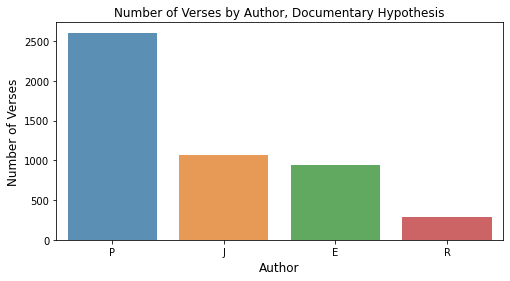

In [7]:
cnt_srs = df['dh_author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Verses', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.title('Number of Verses by Author, Documentary Hypothesis')
plt.show()

/home/cmd/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


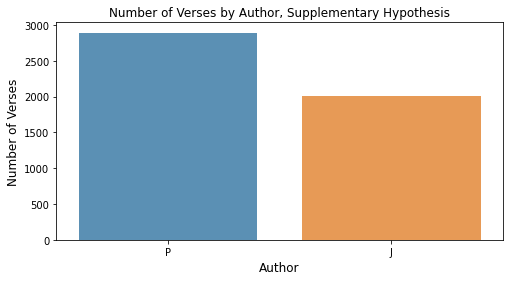

In [8]:
cnt_srs = df['sh_author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Verses', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.title('Number of Verses by Author, Supplementary Hypothesis')

plt.show()

In [9]:
# Create true labels

pos = df['pos'].tolist()
dh_author = df['dh_author']
sh_author = df['sh_author']

dh_to_int = {
    'J': 0,
    'E': 1,
    'P': 2, 
    'R': 3,
}
dh_labels = []
for i, label in enumerate(dh_author):
    dh_labels.append(dh_to_int[label])
df['dh_labels'] = dh_labels
dh_labels = np.array(dh_labels)

sh_to_int = {
    'J': 0,
    'P': 1, 
}
sh_labels = []
for i, label in enumerate(sh_author):
    sh_labels.append(sh_to_int[label])
df['sh_labels'] = sh_labels
sh_labels = np.array(sh_labels)

<a name='embed'></a>
### 3. Embedding Experimentation

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
posv = vectorizer.fit_transform(pos)
posv_arr = posv.toarray()

A note on unsupervised improvment: We calculate k centroids for our dataset where each datapoint is a verse converted to POS and then embedded. Any point within two standard deviations of its respective centroid is kept under the theory that it is a “core datapoint” that best represents that author’s style. All datapoints outside those two standard devations are reclassified using a supervised classification algorithm (the random forest classifer has proven quite effective for this dataset) in which those points within the two standard deviations are used as labeled, true data. This technique and some code is taken from Alon Daks and Aidan Clark’s paper, "Unsupervised Authorial Clustering Based on Syntatic Structure."

In [11]:
k = 4
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(posv)

print('no supervised enhancement f1 score: ', metrics.f1_score(dh_labels, sc_labels, average='weighted'))
print('no supervised enhancement accuracy: ', metrics.accuracy_score(dh_labels, sc_labels))
print()

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(posv_arr, i) for i in cluster_labels]
predicted_labels = supervised_improvement(posv_arr, cluster_cores)
predicted_labels = clean_label(dh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(dh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(dh_labels, predicted_labels))

no supervised enhancement f1 score:  0.20316450088210392
no supervised enhancement accuracy:  0.19881487535758072

f1 score:  0.40496983658968305
accuracy:  0.3835308541070699


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [12]:
k = 2
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(posv)

print('no supervised enhancement f1 score: ', metrics.f1_score(dh_labels, sc_labels, average='weighted'))
print('no supervised enhancement accuracy: ', metrics.accuracy_score(dh_labels, sc_labels))
print()

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(posv_arr, i) for i in cluster_labels]
predicted_labels = supervised_improvement(posv_arr, cluster_cores)
predicted_labels = clean_label(sh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(sh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(sh_labels, predicted_labels))

no supervised enhancement f1 score:  0.12682255578565207
no supervised enhancement accuracy:  0.21005312627707398

f1 score:  0.5937929049364342
accuracy:  0.605026563138537


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [13]:
f = open('fasttext_data.txt', 'w')
for x, y in zip(pos, dh_labels):
    line = '__label__' + str(y) + ' ' + x + '\n'
    f.write(line)
f.close()

model = fasttext.train_unsupervised(input='fasttext_data.txt')

ft_vecs = []
for p in pos:
    vec = model.get_sentence_vector(p)
    ft_vecs.append(vec)
ft_vecs = np.array(ft_vecs)

PCA visulaizations are a great way to see distinctions in data. In a perfect world we would see all authors in neat little clusters with a definitive seperation between their groupings. Unfortunately our data appears to be quite conjoined. This doesn't mean that the model cannot find a distinction between them per se, but it may indicate that the distinction is too complex to be expressed in only two dimensions given our current embedding method. This appears to be the case with our experimentation and the PCA visulaizations tend to be somewhat underwhelming.

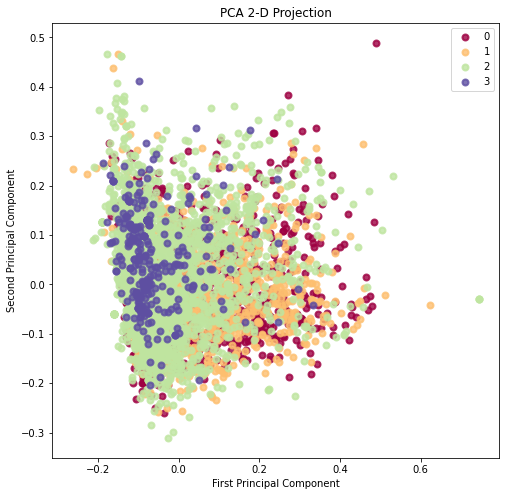

In [14]:
pca = PCA(random_state=5780)
pca.fit(ft_vecs)
skplt.decomposition.plot_pca_2d_projection(pca, ft_vecs, dh_labels, figsize=(8,8))
plt.show()

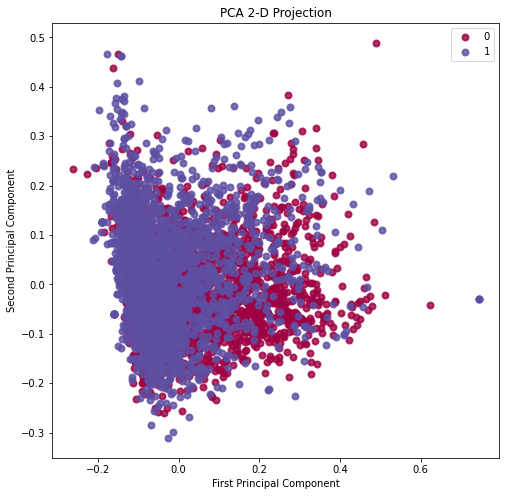

In [15]:
pca = PCA(random_state=5780)
pca.fit(ft_vecs)
skplt.decomposition.plot_pca_2d_projection(pca, ft_vecs, sh_labels, figsize=(8,8))
plt.show()

In [16]:
k = 4
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(ft_vecs)

print('no supervised improvement f1 score: ', metrics.f1_score(dh_labels, sc_labels, average='weighted'))
print('no supervised improvement accuracy: ', metrics.accuracy_score(dh_labels, sc_labels))
print()

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(ft_vecs, i) for i in cluster_labels]
predicted_labels = supervised_improvement(ft_vecs, cluster_cores)
predicted_labels = clean_label(dh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(dh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(dh_labels, predicted_labels))

no supervised improvement f1 score:  0.2766549234761647
no supervised improvement accuracy:  0.24948917041275032

f1 score:  0.33996300850587274
accuracy:  0.3179403351042092


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [17]:
k = 2
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(ft_vecs)

print('no supervised improvement f1 score: ', metrics.f1_score(dh_labels, sc_labels, average='weighted'))
print('no supervised improvement accuracy: ', metrics.accuracy_score(dh_labels, sc_labels))
print()

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(ft_vecs, i) for i in cluster_labels]
predicted_labels = supervised_improvement(ft_vecs, cluster_cores)
predicted_labels = clean_label(sh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(sh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(sh_labels, predicted_labels))

no supervised improvement f1 score:  0.12998971792588504
no supervised improvement accuracy:  0.21373109930527176

f1 score:  0.6491189697591139
accuracy:  0.6722517368205967


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [18]:
dim = 300
w2v_sg_model = word2vec.Word2Vec(sentences=pos, vector_size=dim, window=100, shrink_windows=True, min_count=5, sg=1, hs=0, negative=0, workers=12, seed=5780)

wordvec_arrs = np.zeros((len(pos), dim)) 
for i in range(len(pos)):
    wordvec_arrs[i,:] = word_vector(w2v_sg_model.wv, pos[i], dim)

In [19]:
k = 4
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(wordvec_arrs)

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(wordvec_arrs, i) for i in cluster_labels]
predicted_labels = supervised_improvement(wordvec_arrs, cluster_cores)
predicted_labels = clean_label(dh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(dh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(dh_labels, predicted_labels))

f1 score:  0.3186452904919331
accuracy:  0.2956681651001226


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [20]:
k = 2
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(wordvec_arrs)

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(wordvec_arrs, i) for i in cluster_labels]
predicted_labels = supervised_improvement(wordvec_arrs, cluster_cores)
predicted_labels = clean_label(sh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(sh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(sh_labels, predicted_labels))

f1 score:  0.579295465653621
accuracy:  0.5794850837760523


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [21]:
dim = 300
w2v_cbow_model = word2vec.Word2Vec(sentences=pos, vector_size=dim, window=100, shrink_windows=True, min_count=5, sg=0, hs=0, negative=5, workers=12, seed=5780)

wordvec_arrs = np.zeros((len(pos), dim)) 
for i in range(len(pos)):
    wordvec_arrs[i,:] = word_vector(w2v_cbow_model.wv, pos[i], dim)

In [22]:
k = 4
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(wordvec_arrs)

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(wordvec_arrs, i) for i in cluster_labels]
predicted_labels = supervised_improvement(wordvec_arrs, cluster_cores)
predicted_labels = clean_label(dh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(dh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(dh_labels, predicted_labels))

f1 score:  0.3806501093993769
accuracy:  0.35063342868818964


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [23]:
k = 2
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(wordvec_arrs)

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(wordvec_arrs, i) for i in cluster_labels]
predicted_labels = supervised_improvement(wordvec_arrs, cluster_cores)
predicted_labels = clean_label(sh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(sh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(sh_labels, predicted_labels))

f1 score:  0.6087096578869053
accuracy:  0.6138128320392318


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [24]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
posv = vectorizer.fit_transform(pos)
posv_arr = posv.toarray()

In [25]:
k = 4
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(posv)

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(posv_arr, i) for i in cluster_labels]
predicted_labels = supervised_improvement(posv_arr, cluster_cores)
predicted_labels = clean_label(dh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(dh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(dh_labels, predicted_labels))

f1 score:  0.4074327935610476
accuracy:  0.39088680016346544


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [26]:
k = 2
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(posv)

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(posv_arr, i) for i in cluster_labels]
predicted_labels = supervised_improvement(posv_arr, cluster_cores)
predicted_labels = clean_label(sh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(sh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(sh_labels, predicted_labels))

f1 score:  0.6637101450896153
accuracy:  0.6614221495709032


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [27]:
vectorizer = CountVectorizer(ngram_range=(1, 25), analyzer='char')
posv = vectorizer.fit_transform(pos)
posv_arr = posv.toarray()

In [28]:
k = 4
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(posv)

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(posv_arr, i) for i in cluster_labels]
predicted_labels = supervised_improvement(posv_arr, cluster_cores)
predicted_labels = clean_label(dh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(dh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(dh_labels, predicted_labels))

f1 score:  0.44326977878615503
accuracy:  0.4152022885165509


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [29]:
k = 2
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(posv)

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(posv_arr, i) for i in cluster_labels]
predicted_labels = supervised_improvement(posv_arr, cluster_cores)
predicted_labels = clean_label(sh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(sh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(sh_labels, predicted_labels))

f1 score:  0.677435601141693
accuracy:  0.6753167143440948


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [30]:
vectorizer = TfidfVectorizer(ngram_range=(5, 5), analyzer='char')
posv = vectorizer.fit_transform(pos)
posv_arr = posv.toarray()

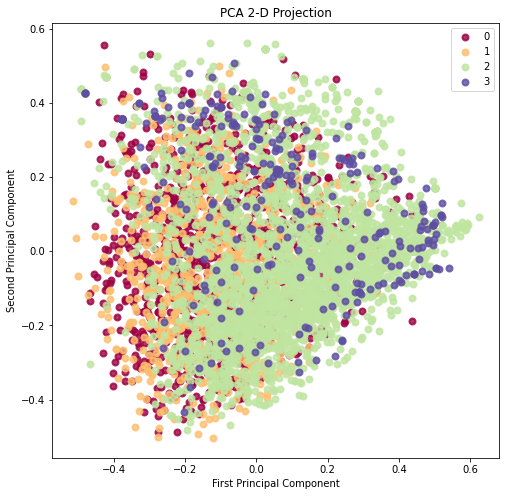

In [31]:
pca = PCA(random_state=5780)
pca.fit(posv_arr)
skplt.decomposition.plot_pca_2d_projection(pca, posv_arr, dh_labels, figsize=(8,8))
plt.show()

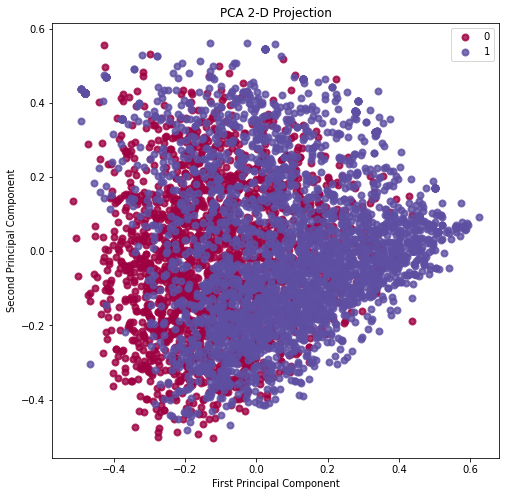

In [32]:
pca = PCA(random_state=5780)
pca.fit(posv_arr)
skplt.decomposition.plot_pca_2d_projection(pca, posv_arr, sh_labels, figsize=(8,8))
plt.show()

In [33]:
k = 4
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(posv)

print('no supervised improvement f1 score: ', metrics.f1_score(dh_labels, sc_labels, average='weighted'))
print('no supervised improvement accuracy: ', metrics.accuracy_score(dh_labels, sc_labels))
print()

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(posv_arr, i) for i in cluster_labels]
predicted_labels = supervised_improvement(posv_arr, cluster_cores)
predicted_labels = clean_label(dh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(dh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(dh_labels, predicted_labels))

no supervised improvement f1 score:  0.2418206641404958
no supervised improvement accuracy:  0.24192889252145483

f1 score:  0.43088766481888485
accuracy:  0.4060073559460564


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [34]:
k = 2
c = SpectralClustering(n_clusters=k, affinity='linear')
sc_labels = c.fit_predict(posv)

print('no supervised improvement f1 score: ', metrics.f1_score(sh_labels, sc_labels, average='weighted'))
print('no supervised improvement accuracy: ', metrics.accuracy_score(sh_labels, sc_labels))
print()

cluster_labels = [[i for i, x in enumerate(sc_labels) if x == j] for j in range(k)]
cluster_cores = [get_core_indices(posv_arr, i) for i in cluster_labels]
predicted_labels = supervised_improvement(posv_arr, cluster_cores)
predicted_labels = clean_label(sh_labels, predicted_labels)

print('f1 score: ', metrics.f1_score(sh_labels, predicted_labels, average='weighted'))
print('accuracy: ', metrics.accuracy_score(sh_labels, predicted_labels))

no supervised improvement f1 score:  0.6770726263029256
no supervised improvement accuracy:  0.6751123825091949

f1 score:  0.6799650132806392
accuracy:  0.6779730281977933


/home/cmd/software/stylometric_analysis_of_the_pentateuch_using_ai/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


<a name='results'></a>
### 4. Results

Our most successful embedding method came from the TFIDF vectorizer with the character level analyzer that recieved supervised improvment. The DH model returned a weighted f1_score of 0.43 and the SH model recieved a weighted f1_score of 0.68. These results indicate that a certain amount of authorial style has been captured but we will move to supervised classification to build a more definitive conclusion. The unsupervised learning was included to show how an authorship identification task might need to take place when using a dataset without precurated true labels. Unsupervised authorship identification may also even need to pick k, the number of authors, which makes the task even more challenging. Picking k is not done in this journal.